# Homework 1

## 1.1

It really depends on the domain we are discussing. In my ethics class, we talked about Daniel Kahneman's concept of system 1 and system 2. System 1 is used for fast, automatic thinking. System 2 is used for slow, effortful thinking. Because system 2 is effortful thinking, it is a lot easier to gain insight through introspection. Whereas if you ask someone how their system 1 thinking works, they will likely have a hard time answering that even if they think carefully because it is hard to consciously observe unconscious thought. (In analogy to computer science, the difference between system 1 and system 2 is a bit like the difference between machine learning and traditional (rules-based) AI.) So, introspection may help for modeling system 2 but not so much for system 1.

It also depends on what your goal is. Computers are great at math and reasoning, capable of complex analytical processes and lots of number-crunching. Humans are really good at intuition. Teaching a computer to think like a human can be a lot harder than teaching a computer to reach a reasonable conclusion (or even just reach the conclusion a human would reach).

In [1]:
from itertools import product
import random
import pandas as pd
import time

In [2]:
import sys
sys.path.append('/home/cmd38/344/cs344-code/tools/aima')  # need to be able to find the module
from csp import CSP, min_conflicts, backtracking_search

In [3]:
from search import Problem, hill_climbing, simulated_annealing, exp_schedule

## 1.2

Describe your TSP problem formulation.

- State: a list of all of the cities, in the order that they are visited
- Action: swap two cities (if A was at index 1 and B was at index 4, now A is at index 4 and B is at index 1)

In [4]:
class TSP(Problem):
    """
    Class for a local search implementation of TSP that assumes all cities are interconnected.
    """
    
    def __init__(self, cities, initial, path_costs, goal=None):
        self.cities = cities
        self.num_cities = len(cities)
        self.path_costs = path_costs  # maps a tuple of cities to their path costs
        super().__init__(initial, goal)
    
    def actions(self, state):
        """
        Get the possible actions, in this case a list of tuples 
        where the tuples contain pairs of indices that could be swapped
        """
        acts = []
        for i in range(self.num_cities - 1):  # we swap forward, so we don't need the last city
            for j in range(i + 1, self.num_cities):  # i+1 so we don't swap identical elements
                acts.append((i, j))
        return acts
    
    def result(self, state, action):
        res = state[:]
        i, j = action
        res[i], res[j] = res[j], res[i]
        return res
    
    def value(self, state):
        val = 0
        for idx, city in enumerate(state):
            # for the last city, wrap around (we need to end where we started)
            next_city = state[(idx + 1) %  self.num_cities]
            pair = (city, next_city)
            if pair in self.path_costs:
                val -= self.path_costs[pair]
            else:
                # the pair must be stored in the opposite order, so reverse the tuple
                val -= self.path_costs[pair[::-1]]
        return val

Describe your sample city-domain and how your code does on it.

In [5]:
def try_problem(cities, cost):
    results = []
    for _ in range(50):  # random restarts
        # like random.shuffle, but returns a new list instead of modifying the original
        initial = random.sample(cities, k=len(cities))
        p = TSP(cities, initial, cost)

        t_start = time.time()
        hill_solution = hill_climbing(p)
        t_hill = time.time() - t_start

        t_start = time.time()
        annealing_solution = simulated_annealing(
            p,
            exp_schedule(k=20, lam=0.005, limit=1000)
        )
        t_anneal = time.time() - t_start

        results.append({"Initial": initial, "x_hill": hill_solution, "val_hill": p.value(hill_solution),
                    "time_hill": t_hill, "x_anneal": annealing_solution, "val_anneal": p.value(annealing_solution),
                    "time_anneal": t_anneal})
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [6]:
# simple example from https://www.geeksforgeeks.org/travelling-salesman-problem-set-1/
cities = [1, 2, 3, 4]
cost = {(1, 2): 10, (1, 3): 15, (1, 4): 20, (2, 3): 35, (2, 4): 25, (3, 4): 30}

simple_df = try_problem(cities, cost)

In [7]:
print(simple_df.describe())

       val_hill  time_hill  val_anneal  time_anneal
count      50.0  50.000000        50.0    50.000000
mean      -80.0   0.000049       -80.0     0.012731
std         0.0   0.000012         0.0     0.000375
min       -80.0   0.000028       -80.0     0.012197
25%       -80.0   0.000038       -80.0     0.012435
50%       -80.0   0.000053       -80.0     0.012777
75%       -80.0   0.000056       -80.0     0.012934
max       -80.0   0.000080       -80.0     0.014077


Both algorithms easily solve the simple case.

In [8]:
# Example 4 from http://jlmartin.faculty.ku.edu/~jlmartin/courses/math105-F14/chapter6-part6.pdf
cities = ['A', 'B', 'C', 'D', 'E', 'F']
cost = {('A', 'B'): 12, ('A', 'C'): 29, ('A', 'D'): 22, ('A', 'E'): 13, ('A', 'F'): 24,
               ('B', 'C'): 19, ('B', 'D'): 3, ('B', 'E'): 25, ('B', 'F'): 6,
               ('C', 'D'): 21, ('C', 'E'): 23, ('C', 'F'): 28,
               ('D', 'E'): 4, ('D', 'F'): 5, ('E', 'F'): 16}

complex_df = try_problem(cities, cost)

In [9]:
print(complex_df.describe())

       val_hill  time_hill  val_anneal  time_anneal
count      50.0  50.000000        50.0    50.000000
mean      -76.0   0.000218       -76.0     0.023469
std         0.0   0.000079         0.0     0.000636
min       -76.0   0.000067       -76.0     0.022720
25%       -76.0   0.000186       -76.0     0.022949
50%       -76.0   0.000190       -76.0     0.023293
75%       -76.0   0.000251       -76.0     0.023938
max       -76.0   0.000424       -76.0     0.025265


Both algorithms solve the complex case and do better than the algorithms in the notes I got this example from (those algorithms got -84 and -83).

I think hill climbing is better since it works faster and there don't tend to be a lot of local maxima (I don't think? I'm having a hard time visualizing it). But I may not have tried on a hard enough problem.

In [10]:
num_cities = 30
cities = list(range(num_cities))
cost = dict()
for i in range(num_cities - 1):  # we swap forward, so we don't need the last city
    for j in range(i + 1, num_cities):  # i+1 so we don't swap identical elements
        cost[(i, j)] = random.uniform(1, 500)  # generate a random cost between 1 and 500
random_df = try_problem(cities, cost)

In [11]:
print(random_df.describe())

          val_hill  time_hill   val_anneal  time_anneal
count    50.000000  50.000000    50.000000    50.000000
mean  -1948.019883   0.075208 -2177.504884     0.810757
std     212.151321   0.016559   228.674927     0.018118
min   -2366.078738   0.050322 -2591.835345     0.783650
25%   -2105.959821   0.063621 -2349.784539     0.796371
50%   -1954.730771   0.073486 -2196.740338     0.809969
75%   -1801.915249   0.084197 -1995.714937     0.820077
max   -1534.918367   0.130614 -1577.756556     0.860386


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

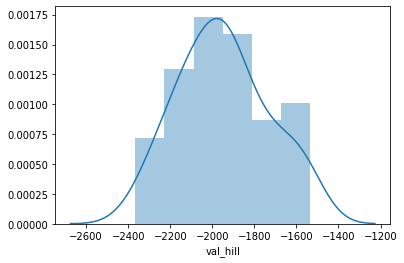

In [13]:
sns.distplot(random_df['val_hill'])

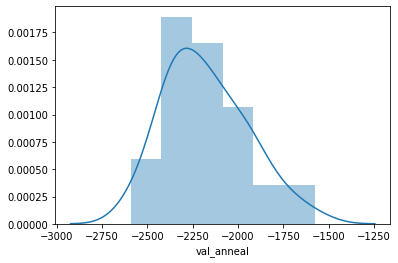

In [14]:
sns.distplot(random_df['val_anneal'])

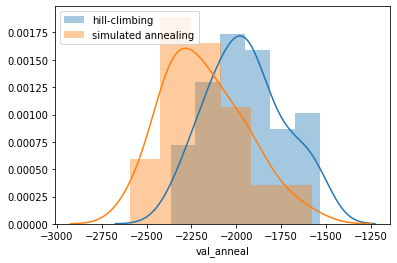

In [15]:
sns.distplot(random_df['val_hill'], label="hill-climbing")
sns.distplot(random_df['val_anneal'], label="simulated annealing")
plt.legend()

So we can see here that on our larger example (30 cities with random path costs), hill_climbing does better. It gets better values, and it also takes less time to complete.

## 1.3

Your solution should represent 6–7 courses (e.g., cs108, cs112, …), 4–5 faculty (e.g., dschuurman, adams, …) course assignments for all courses (e.g., dschuurman teaches 108, adams teaches cs112, …), 4–5 (disjoint!) time slots (mwf900, tth1030, …) and the 2 CS classrooms (e.g., nh253, sb382).

The constraints are that:
- each course should be offered exactly once by the assigned faculty member.
- a faculty member can only teach one thing at a time.
- a room can only have one class at each time.

In [16]:
def CourseScheduling(courses, course_assignments, time_slots, classrooms):
    """Return an instance of a course scheduling problem"""
    combinations = list(product(time_slots, classrooms))
    
    variables = courses
    domains = {course: combinations[:] for course in courses}
    neighbors = dict()
    for course in courses:
        neighbors[course] = [x for x in courses if x != course]
    
    def course_constraint(A, a, B, b):
        time_a, room_a = a
        time_b, room_b = b
        if time_a == time_b:
            if room_a == room_b:
                # a room can only have one class at each time
                return False
            if course_assignments[A] == course_assignments[B]:
                # a faculty member can only teach one thing at a time
                return False
        return True
    
    return CSP(variables, domains, neighbors, course_constraint)

In [17]:
courses = ["cs108", "cs112", "cs214", "cs232", "cs344", "cs262", "cs384"]
faculty = ["Adams", "Norman", "Schuurman", "Vander Linden"]
course_assignments = {"cs108": "Norman", "cs112": "Adams", 
                      "cs214": "Adams", "cs232": "Norman", "cs344": "Vander Linden",
                      "cs262": "Vander Linden", "cs384": "Schuurman"}
time_slots = ["mwf900", "mwf1030", "mwf1130", "tth900", "tth1030"]
classrooms = ["nh253", "sb382"]
problem = CourseScheduling(courses, course_assignments, time_slots, classrooms)

I chose this formulation of the problem because:

- by making the courses the variables and the combinations of times and rooms the values, the problem automatically satisfies the "each course should be offered exactly once" 
- there are only two possible conflicts: a course in two places at the same time, and a professor in two places at the same time. The way I set up this problem, it is easy to check both of those conflicts in the course_constraint function

Here I demonstrate that my formulation works for min_conflicts and backtracking. I was not able to get it to work using AC3, but AC3 couldn't solve some other csp's either.

In [18]:
solution_min = min_conflicts(problem)

In [19]:
solution_back = backtracking_search(problem)

In [20]:
for solution in (solution_min, solution_back):
    if solution is not None and problem.goal_test(solution):
        print('Solution:')
        print(solution)
    else:
        print('Failed - domains: ' + str(problem.curr_domains))
        problem.display(problem.infer_assignment())

Solution:
{'cs108': ('tth1030', 'sb382'), 'cs112': ('mwf900', 'sb382'), 'cs214': ('mwf1030', 'nh253'), 'cs232': ('mwf1130', 'sb382'), 'cs344': ('tth900', 'nh253'), 'cs262': ('mwf1030', 'sb382'), 'cs384': ('tth900', 'sb382')}
Solution:
{'cs108': ('mwf900', 'nh253'), 'cs112': ('mwf900', 'sb382'), 'cs214': ('mwf1030', 'nh253'), 'cs232': ('mwf1030', 'sb382'), 'cs344': ('mwf1130', 'nh253'), 'cs262': ('tth900', 'nh253'), 'cs384': ('mwf1130', 'sb382')}
